## VIsion Transformer
### AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE.

## 0. [Import Modules](#0.-Import-Modules)
## 1. [Patch Proccessing](#1.-Patch-Proccessing)
## 2. [Modeling](#2.Modeling)

## 0. Import Modules

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn, Tensor
from torchvision.transforms import Compose, Resize, ToTensor

from PIL import Image

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

## 1. Patch Proccessing

### Load Image

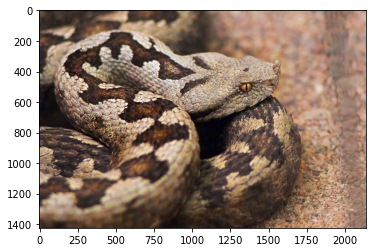

In [2]:
img = Image.open('./imgs/sample.png')

fig = plt.figure()
plt.imshow(img)

### To Tensor

In [3]:
transform = Compose([Resize((224, 224)), ToTensor()])

In [4]:
x = transform(img)
x = x.unsqueeze(0)
x.shape

torch.Size([1, 3, 224, 224])

### To Multiple Patches

- [batch, channel, original_h, original_w] ->
- [batch, channel, (vertical patch num * patch height), (horizontal patch num * patch width)]
- [batch, (vertical patch num * horizontal patch num), (patch height * patch width * channel]
- [1, 3, 224, 224] -> [1, (14 * 14), (16 * 16 * 3)]

In [5]:
patch_size = 16  # this is patch size

patches = rearrange(x, 'b c (vpn ph) (hpn pw) -> b (vpn hpn) (ph pw c)', ph=patch_size, pw=patch_size)

In [6]:
patches.shape

torch.Size([1, 196, 768])

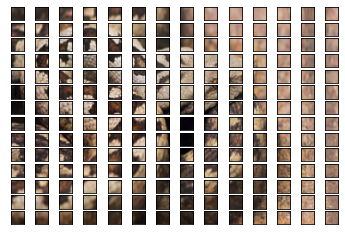

In [7]:
figure, axes = plt.subplots(14, 14)
for i, patch in enumerate(patches[0]):
    axes[i//14][i%14].imshow(patch.view(patch_size, patch_size, 3))
    axes[i//14][i%14].set_xticks([])
    axes[i//14][i%14].set_yticks([])

### PatchEmbedding
- The original author didn't use the [above method](#To-Multiple-Patches) directly.
- But, used Conv2d layer instead of Linear layer for performance gain.
- It can be simply done by setting kernel_size and stride to patch_size.

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int=3, 
                 patch_size:  int=16):
        
        super().__init__()
        
        emb_size = patch_size * patch_size * in_channels
        
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
    
    def forward(self, x):
        return self.projection(x)

In [9]:
print(x.shape)
patch_embedds = PatchEmbedding()(x)
print(patch_embedds.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 196, 768])


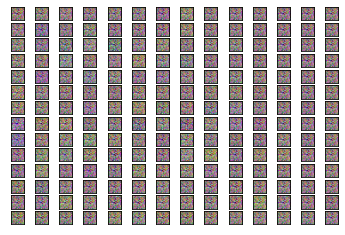

In [10]:
figure, axes = plt.subplots(14, 14)
for i, patch in enumerate(patch_embedds[0].detach()):
    patch = patch.view(patch_size, patch_size, 3).numpy()
    patch = (patch - patch.min(axis=(0,1))) / (patch.max(axis=(0,1)) - patch.min(axis=(0,1)))
    axes[i//14][i%14].imshow(patch)
    axes[i//14][i%14].set_xticks([])
    axes[i//14][i%14].set_yticks([])

### Class Token
- VIsion transformer uses transformer encoder.
- So, the input and output length are same.
- But, we need an **Output that indicates Which Class the Image is**.
- The author added arbitrary extra embedding vector which is learnable.
- The output of this extra embedding vector is fed to MLP Head.
- <img src="imgs/class_token.jpg"/>

In [13]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int=3, 
                 patch_size:  int=16):
        
        super().__init__()
        
        emb_size = patch_size * patch_size * in_channels
        
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        
        # Class Token
        self.class_tok = nn.Parameter(torch.randn(1, 1, emb_size))
    
    def forward(self, x):
        # repeat class token batch_size times
        batch_size = x.shape[0]
        class_toks = repeat(self.class_tok, '() n e -> b n e', b=batch_size)
        
        x = self.projection(x)
        
        # Just concatenate class_toks in front of patch embeddings
        x = torch.cat([class_toks, x], dim=1)
        return x

In [14]:
print(x.shape)
patch_embedds = PatchEmbedding()(x)
print(patch_embedds.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 197, 768])


### Positional Embedding
- Flattened patches doesn't have any positional information.
- Let's train the positional information together.
    * class token : Umm... Zeroth positional embedding vector
    * First patch : First positional embedding vector
    * Second patch : Second positional embedding vector
    * ...

In [16]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int=3, 
                 patch_size:  int=16,
                 img_size:    int=224  # to determine the number of Positional Embeddings
                ):
        
        super().__init__()
        
        emb_size = patch_size * patch_size * in_channels
        patch_num = img_size // patch_size ** 2
        
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        
        # Class Token
        self.class_tok = nn.Parameter(torch.randn(1, 1, emb_size))
        
        # Positional Embeddings
        self.pos_embs = nn.Parameter(torch.randn(patch_num+1, emb_size))
    
    def forward(self, x):
        # repeat class token batch_size times
        batch_size = x.shape[0]
        class_toks = repeat(self.class_tok, '() n e -> b n e', b=batch_size)
        
        x = self.projection(x)
        
        # Just concatenate class_toks in front of patch embeddings
        x = torch.cat([class_toks, x], dim=1)
        
        # Add Positional Embeddings
        x = torch.add(x, self.pos_embs)
        return x

In [17]:
print(x.shape)
patch_embedds = PatchEmbedding()(x)
print(patch_embedds.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 197, 768])


## 2. Modeling

### Attention
- Scale Dot Product Attention<br>
<img src='imgs/scale_dot_product_attention.jpg' width=500/>
- Multi head Attention<br>
<img src='imgs/multi_head_attention.jpg' width=500/>